In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns_nb import *

# Konkrétny príklad samonastavujúceho sa regulátora

(<i>nasledujúce predpokladá znalosť konkrétneho príkladu z učebného textu</i>)

V predchádzajúcom bola prezentovaná simulačná schéma, v ktorej bol implementovaný algoritmus RMNŠ.

Tu je cieľom doplniť do simulačnej schémy výpočet, ktorý na základe priebežne identifikovaných parametrov riadeného systému vypočíta hodnoty parametrov daného zákona riadenia a následne vypočíta samotný akčný zásah.

Výpočet parametrov zákona riadenia využíva matódu rozmistňovania pólov URO a je dplnený výpočtom pre zabezpečenie nulovej trvalej regulačnej odchýlky.

Nech želaným charakteristickým polynómom (pre uvažovaný konkrétny príklad) je $P(z^{-1}) = 1 + p_1z^{-1} + p_2z^{-2}$ pričom $p_1 = -1,6$ a~$p_2 = 0,64$, teda dvojnásobný koreň $z_{1,2} = 0,8$.

Pozn: pre uvažovaný príklad sa odporúča perióda vzorkovania $T_{vz} = 0,1$ [s].

V tomto konkrétnom príklade uvažovaný zákon riadenia je možné zapísať v tvare diferenčnej rovnice:
$$
\begin{equation}
	u(k) =  - r_1 u(k-1) - s_0 y(k) - s_1 y(k-1) + t_0 r(k)
\end{equation}
$$

Hodnoty parametrov modelu $a_1$, $a_2$, $b_1$ a $b_2$ sú po identifikácii (v danej perióde vzorkovania) známe a prirodzene sú známe aj hodnoty koeficientov želaného polynómu $P$. Hodnoty parametrov regulátora získame riešením

$$
\begin{equation}
	\begin{bmatrix} 1 & b_1 & 0 \\ a_1 & b_2 & b_1 \\ a_2 &   0 & b_2 \end{bmatrix}
	\begin{bmatrix} r_1 \\ s_0 \\ s_1  \end{bmatrix}
	=
	\begin{bmatrix} p_1 - a_1 \\ p_2 - a_2 \\ 0 \end{bmatrix}
\end{equation}
$$
a
$$
\begin{equation}
		t_0 = \frac{1 + p_1 + p_2}{b_1 + b_2}
\end{equation}
$$

Funkcia, ktorá realizuje diferenciálne rovnice riadeného systému imporotovaná tu:

In [2]:
import plantFcns

Simulačnú schému nech realizuje nasledujúca funkcia:

In [3]:
def fcn_simSch_05_STR(t_start, T_s, finalIndex, sig_r_ext):

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_0 = np.array([0, 0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------

    u_log = np.zeros([finalIndex, 1])

    #-----------------------------------------

    RMNS_theta_0 = np.array([[ -1.5],
                             [ 0.5],
                             [ -2e-5],
                             [ 1.5e-3]])

    RMNS_theta_log = np.zeros([finalIndex, len(RMNS_theta_0)])
    RMNS_theta_log[0,:] = RMNS_theta_0.reshape(1,-1)

    RMNS_P_0 = np.diag([10*2, 10**2, 10**5, 10**5])

    RMNS_P_log = np.zeros([finalIndex, RMNS_P_0.size])
    RMNS_P_log[0,:] = RMNS_P_0.reshape(1,-1)

    RMNS_y_predict_log = np.zeros([finalIndex, 1])


    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(plantFcns.fcn_difRovnice,
                        x_log[idx-1,:],
                        timespan,
                        args=(u_log[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]

        #--------------------
        # ALGORITMUS RMNS
        y_k = x_log[idx,0]

        h_k = np.array([[-x_log[idx-1,0]],
                        [-x_log[idx-2,0]],  # pozor na to idx-2 !!!
                        [u_log[idx-1,0]],
                        [u_log[idx-2,0]],  # pozor na to idx-2 !!!
                        ])

        theta_km1 = RMNS_theta_log[idx-1,:].reshape(4,-1)
        P_km1 = RMNS_P_log[idx-1,:].reshape(4,4)

        #----------
        e_k = y_k - np.matmul(h_k.T, theta_km1)

        lambdaKoef = 0.95

        Y_k =  np.matmul(P_km1, h_k) / (lambdaKoef + np.matmul(np.matmul(h_k.T, P_km1), h_k))

        P_k = (1/lambdaKoef) * (P_km1 - np.matmul(np.matmul(Y_k, h_k.T), P_km1))
        theta_k = theta_km1 + Y_k * e_k

        #----------

        RMNS_theta_log[idx,:] = theta_k.reshape(1,-1)
        RMNS_P_log[idx,:] = P_k.reshape(1,-1)

        RMNS_y_predict_log[idx,:] = np.matmul(h_k.T, theta_km1)

        #--------------------
        # Vypocty pre parametre zakona riadenia a akcny zasah

        # koeficienty zelaneho polynomu:

        par_p1 = -1.6
        par_p2 = 0.64

        # parametre riadeneho systemu

        par_a1 = RMNS_theta_log[idx-1,0]
        par_a2 = RMNS_theta_log[idx-1,1]
        par_b1 = RMNS_theta_log[idx-1,2]
        par_b2 = RMNS_theta_log[idx-1,3]
        
        # Parametre RST regulatora

        matrix_A = np.array([[     1, par_b1,      0],
                             [par_a1, par_b2, par_b1],
                             [par_a2,      0, par_b2],
                             ])

        matrix_b = np.array([[par_p1 - par_a1],
                             [par_p2 - par_a2],
                             [0],
                             ])

        par_r1, par_s0, par_s1, = np.linalg.solve(matrix_A, matrix_b)

        par_t0 = (1 + par_p1 + par_p2)/(par_b1 + par_b2)

        # vypocita sa akcny zasah u(k)

        par_RST = np.array([par_r1, par_s0, par_s1, par_t0])
        vekt_omega = np.array([-u_log[idx-1,:], -x_log[idx,0], -x_log[idx-1,0], sig_r_ext[idx,0]])

        u_log[idx,:] = np.dot(par_RST, vekt_omega)

        #--------------------

    return [t_log, x_log, u_log, RMNS_y_predict_log, RMNS_theta_log]

V uvedenej simulačnej schéme je implementovaný RMNŠ algoritmus rovnako ako v predchádzajúcom...

Všimnime si však, že faktor zabúdania $\lambda$ (premenná ```lambdaKoef```) je nastavený na hodnotu $\lambda = 0,95$.

Tiež je potrebné všimnúť si, že štartovacie hodnoty RMNŠ algoritmu sú:

```RMNS_theta_0 = np.array([[-1.5], [0.5], [-2e-5], [1.5e-3]])```

a

```RMNS_P_0 = np.diag([10*2, 10**2, 10**5, 10**5])```



Nastavenia potrebné pre samotnú simuláciu a vygenerovanie signálov, ktoré sa používajú pri simulácii (ktoré sú dopredu známe - dané):

In [4]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 38
sim_T_s = 0.1
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)


# Preddefinovane signaly

period_time = 40
period_tab = np.array([
                      [0, 1],
                      [10, 0],
                      [20, -1],
                      [30, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):

    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break

sig_r_ext = sig_vysl

Spustenie simulácie:

In [5]:
# Spustenie simulacie

t_log, x_log, u_log, RMNS_y_predict_log, RMNS_theta_log = fcn_simSch_05_STR(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_r_ext,
    )

Nakreslenie obrázku:

<IPython.core.display.Javascript object>


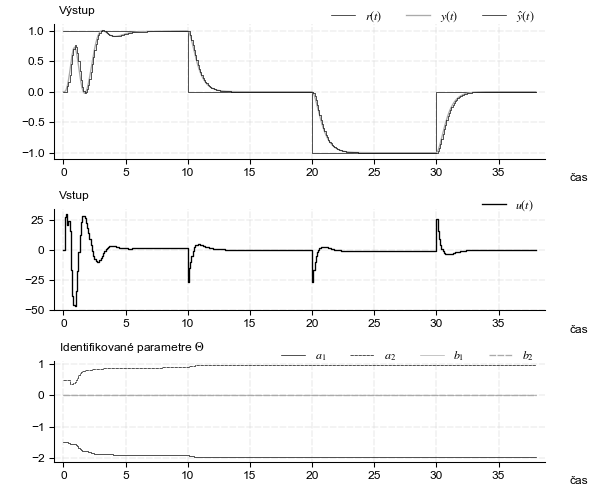

In [6]:
figNameNum = 1
execfile('misc/v_fig_STR.py')